In [1]:
#Figure 4 and 6, the behavioral and network analysis. will need to include the network bits

import torch, sys, os, io, pickle, json
from os.path import exists
import numpy as np
from scipy.special import softmax
from scipy import stats
from scipy.stats import ranksums, wilcoxon

import matplotlib.pyplot as plt
import matplotlib


from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot
from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.analysis import state_analysis as sta

%load_ext autoreload
%autoreload 2

dbase = '/Users/dhocker/projects/dynamics/results/20231003/'

In [2]:
# which fig is being considered
#fig2do = '4'  # Fig 4. behavior
fig2do = '6' # Fig 6. sham behavior

#indices of CL types for each plot
klist_dict = {'4': [0,1,2], '6':[0,7,8]}
labs = ['kind', 'nok_cl','nok_nocl','_','_','_','_','sham_w','sham_wo']
kuse = [10,60,40,10,10,10,10,10,10]  # the maximum index for the final stage 5 and stage 6 training stage, by s_idx
num_rnns = {0:50, 1:20, 2:20, 3:10, 4:10, 5:10, 6:10, 7:10, 8:10}  # number of RNNs per training type, by sidx

In [8]:
# 3A, inset reward per gradient step (i.e., rewardrate), at end of training

rr_means = []
rr_sems = []
rr_sampsforstats = []

#select averaging function
uf = np.nanmean
#uf = np.nanmedian

dt = 0.05

for k in klist_dict[fig2do]:
    
    # initialize and determine max number of RNNs
    rr = []
    maxidx = num_rnns[k]  # max number of RNNs
    tphase = 5

    for j in range(1,maxidx+1):
        print([k,j],end='\r')
        
        #get name
        d = utils.getfnames(j, k, tphase, kuse[k], dbase=dbase,
              reg_idx=0, block='mixed', epoch='wait')
        
        fname_behdat = d['allbeh']
        fname_dat = d['dat']

        
        if exists(fname_behdat):       
            try:
                dat_stat = utils.retrieve_behdat(fname_behdat,fname_dat)
                if dat_stat is not None:
                    rr.append(uf(dat_stat['rewardrate_pergradstep'])/dt)
                else:
                    print('data didnt exist?')
                    print(fname_stat)
            except:
                print('json error: ' +str(j))
                print(fname_dat)
        else:
            print('skipping beh file:'+fname_behdat)
        
    print('number of RNNs per CL')        
    print(len(rr))
    print('---')
    rr_means.append(np.nanmean(rr))
    rr_sampsforstats.append(rr)
    rr_sems.append(np.std(rr)/np.sqrt(len(rr))) 

data didnt exist?
json error: 45
/Users/dhocker/projects/dynamics/results/20231003/full_cl/45/rnn_curric_45_block_10.json
number of RNNs per CL
49
---
number of RNNs per CL
20
---
data didnt exist?
json error: 2
/Users/dhocker/projects/dynamics/results/20231003/nok_nocl/2/rnn_curric_2_block_40_1k.json
data didnt exist?
json error: 6
/Users/dhocker/projects/dynamics/results/20231003/nok_nocl/6/rnn_curric_6_block_40_1k.json
number of RNNs per CL
18
---


rank sum of reward rates for best models
kindergarten + shaping vs. shaping
RanksumsResult(statistic=4.695230505989368, pvalue=2.663062512995643e-06)
shaping vs. no shaping
RanksumsResult(statistic=2.3388213848187442, pvalue=0.019344679488019316)


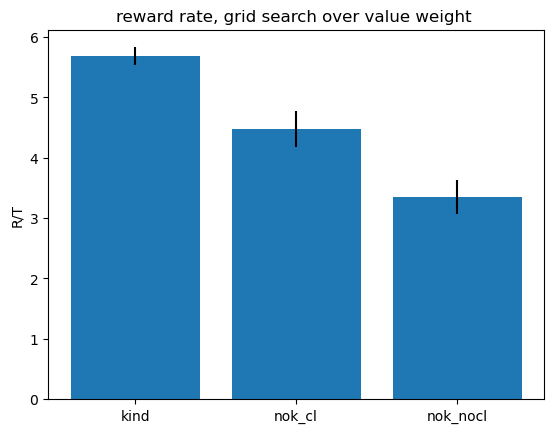

In [18]:
#Fig 4C. comparison between kindergarten + shaping and best alternative. final stage of training
print('rank sum of reward rates for best models')

txt0 = 'kindergarten + shaping'
if fig2do == '4':
    txt1 = 'shaping'
    txt2 = 'no shaping'
else:
    txt1 = 'd2m + mem + int'
    txt2 = 'd2m'

print(txt0 +  ' vs. ' +txt1)
print(ranksums(rr_sampsforstats[0],rr_sampsforstats[1]))
print(txt1 +  ' vs. ' +txt2)
print(ranksums(rr_sampsforstats[1],rr_sampsforstats[2]))


ntype = len(labs_fig)+1
fig = plt.figure()
plt.bar(range(1,ntype),rr_means)
plt.errorbar(range(1,ntype), rr_means, rr_sems, color = 'k', linestyle = 'none')
plt.ylabel('R/T')
plt.title('reward rate, grid search over value weight ')
plt.xticks(range(1,ntype), labels=labs_fig)
plt.show()

In [10]:
#$4B data. calculate reward per gradient step. across-training comparison across CL types

rr_means_all = []
rr_sems_all = []
dt = 0.05

for s_idx in klist_dict[fig2do]:

    #for each CL type
    rr_means_k = []
    rr_sems_k = []
    
    for tphase in [3,4,5]:  

        if tphase == 5:
            nmax = kuse[s_idx] # max idx for block part of training, for that CL type
        else:
            nmax = 10
            
        for idx in range(1,nmax+1):
     
            rr_idx = []  # for each index    
            maxidx = num_rnns[s_idx]  # max number of RNNs

            for num in range(1,maxidx+1):
                print([s_idx,tphase, idx, num],end='\r')
                                     
                #grab fnames
                d = utils.getfnames(num, s_idx, tphase, idx, dbase=dbase,
                                    reg_idx=0, block='mixed', epoch='wait')      
                fname_behdat = d['allbeh']
                fname_dat = d['dat'].split('/')[-1]
                
                    
                if exists(fname_behdat):      
                    try:
                        dat_stat = utils.retrieve_behdat(fname_behdat,fname_dat)
                        if dat_stat is not None:                        
                            rr_idx.append(uf(dat_stat['rewardrate_pergradstep'])/dt)
                        else:
                            print('missing file in behdat: '+fname_fun_dat_k(num,idx, s_idx))
                    except:
                        #print('Json error: ' + str([s_idx,tphase,num,idx]))
                        # found that intentionally missing data for nok_nocl case kept ending up here.
                        # generated lots of error messages. TODO handle this case better
                        continue  
      
            # puts np.nan if no data present. adds as padding for nok_nocl case
            rr_means_k.append(uf(rr_idx))
            rr_sems_k.append(np.nanstd(rr_idx)/np.sqrt(len(rr_idx)))       

    rr_means_all.append(rr_means_k)
    rr_sems_all.append(rr_sems_k)
    

Json error: [0, 4, 49, 2]
Json error: [0, 4, 46, 3]
Json error: [0, 4, 49, 3]
Json error: [0, 4, 46, 4]
Json error: [0, 4, 50, 10]
Json error: [0, 5, 13, 1]
Json error: [0, 5, 48, 1]
Json error: [0, 5, 50, 1]
Json error: [0, 5, 21, 5]
Json error: [0, 5, 6, 6]
Json error: [0, 5, 27, 6]
Json error: [0, 5, 27, 7]
Json error: [0, 5, 14, 8]
Json error: [0, 5, 15, 8]
Json error: [0, 5, 1, 9]
Json error: [0, 5, 5, 9]
Json error: [0, 5, 19, 9]
Json error: [0, 5, 22, 9]
Json error: [0, 5, 25, 9]
Json error: [0, 5, 41, 9]
Json error: [0, 5, 42, 9]
Json error: [0, 5, 44, 9]
Json error: [0, 5, 45, 9]
Json error: [0, 5, 45, 10]
Json error: [2, 3, 1, 1]
Json error: [2, 3, 2, 1]
Json error: [2, 3, 3, 1]
Json error: [2, 3, 4, 1]
Json error: [2, 3, 5, 1]
Json error: [2, 3, 6, 1]
Json error: [2, 3, 7, 1]
Json error: [2, 3, 8, 1]
Json error: [2, 3, 9, 1]
Json error: [2, 3, 10, 1]
Json error: [2, 3, 11, 1]
Json error: [2, 3, 12, 1]
Json error: [2, 3, 13, 1]
Json error: [2, 3, 14, 1]
Json error: [2, 3, 15,

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_16842/49189807.py:45: RuntimeWarning: Mean of empty slice
  rr_means_k.append(uf(rr_idx))
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Json error: [2, 3, 9, 2]
Json error: [2, 3, 10, 2]
Json error: [2, 3, 11, 2]
Json error: [2, 3, 12, 2]
Json error: [2, 3, 13, 2]
Json error: [2, 3, 14, 2]
Json error: [2, 3, 15, 2]
Json error: [2, 3, 16, 2]
Json error: [2, 3, 17, 2]
Json error: [2, 3, 18, 2]
Json error: [2, 3, 19, 2]
Json error: [2, 3, 20, 2]
Json error: [2, 3, 1, 3]
Json error: [2, 3, 2, 3]
Json error: [2, 3, 3, 3]
Json error: [2, 3, 4, 3]
Json error: [2, 3, 5, 3]
Json error: [2, 3, 6, 3]
Json error: [2, 3, 7, 3]
Json error: [2, 3, 8, 3]
Json error: [2, 3, 9, 3]
Json error: [2, 3, 10, 3]
Json error: [2, 3, 11, 3]
Json error: [2, 3, 12, 3]
Json error: [2, 3, 13, 3]
Json error: [2, 3, 14, 3]
Json error: [2, 3, 15, 3]
Json error: [2, 3, 16, 3]
Json error: [2, 3, 17, 3]
Json error: [2, 3, 18, 3]
Json error: [2, 3, 19, 3]
Json error: [2, 3, 20, 3]
Json error: [2, 3, 1, 4]
Json error: [2, 3, 2, 4]
Json error: [2, 3, 3, 4]
Json error: [2, 3, 4, 4]
Json error: [2, 3, 5, 4]
Json error: [2, 3, 6, 4]
Json error: [2, 3, 7, 4]
Jso

Json error: [2, 4, 17, 8]
Json error: [2, 4, 18, 8]
Json error: [2, 4, 19, 8]
Json error: [2, 4, 20, 8]
Json error: [2, 4, 1, 9]
Json error: [2, 4, 2, 9]
Json error: [2, 4, 3, 9]
Json error: [2, 4, 4, 9]
Json error: [2, 4, 5, 9]
Json error: [2, 4, 6, 9]
Json error: [2, 4, 7, 9]
Json error: [2, 4, 8, 9]
Json error: [2, 4, 9, 9]
Json error: [2, 4, 10, 9]
Json error: [2, 4, 11, 9]
Json error: [2, 4, 12, 9]
Json error: [2, 4, 13, 9]
Json error: [2, 4, 14, 9]
Json error: [2, 4, 15, 9]
Json error: [2, 4, 16, 9]
Json error: [2, 4, 17, 9]
Json error: [2, 4, 18, 9]
Json error: [2, 4, 19, 9]
Json error: [2, 4, 20, 9]
Json error: [2, 4, 1, 10]
Json error: [2, 4, 2, 10]
Json error: [2, 4, 3, 10]
Json error: [2, 4, 4, 10]
Json error: [2, 4, 5, 10]
Json error: [2, 4, 6, 10]
Json error: [2, 4, 7, 10]
Json error: [2, 4, 8, 10]
Json error: [2, 4, 9, 10]
Json error: [2, 4, 10, 10]
Json error: [2, 4, 11, 10]
Json error: [2, 4, 12, 10]
Json error: [2, 4, 13, 10]
Json error: [2, 4, 14, 10]
Json error: [2, 

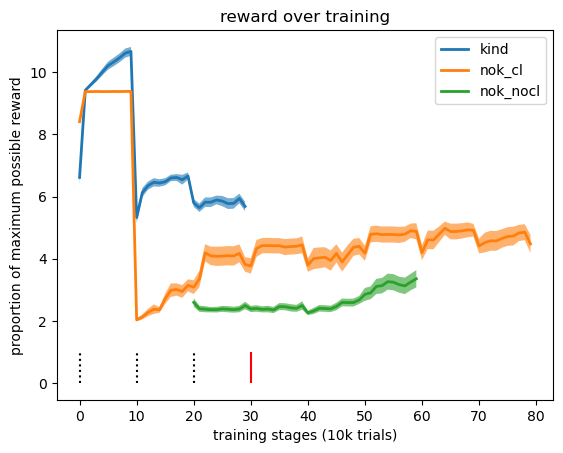

In [16]:
#Fig 4B, plotting

#set figure names
labs_fig = np.array(labs)[klist_dict[fig2do]]

n = len(rr_means_all[0])
n1 = len(rr_means_all[1])
n2 = len(rr_means_all[2])

plt.fill_between(range(n),np.array(rr_means_all[0])+np.array(rr_sems_all[0]) , 
                 np.array(rr_means_all[0])-np.array(rr_sems_all[0]), alpha = 0.6)
plt.plot(range(n),rr_means_all[0], linewidth=2, label=labs_fig[0])

plt.fill_between(range(n1),np.array(rr_means_all[1])+np.array(rr_sems_all[1]) , 
                 np.array(rr_means_all[1])-np.array(rr_sems_all[1]), alpha = 0.6)
plt.plot(range(n1),rr_means_all[1], linewidth=2,label=labs_fig[1])

plt.fill_between(range(n2),np.array(rr_means_all[2])+np.array(rr_sems_all[2]) , 
                 np.array(rr_means_all[2])-np.array(rr_sems_all[2]), alpha = 0.6)
plt.plot(range(n2),rr_means_all[2], linewidth=2,label=labs_fig[2])


plt.xticks([0,10,20,30,40,50,60,70,80])
[plt.vlines(k,0,1.0, linestyle='dotted', color = 'k') for k in [0,10,20] ]
plt.vlines(30,0,1.0, color = 'r',linestyle = 'solid')
plt.xlabel('training stages (10k trials)')
plt.ylabel('proportion of maximum possible reward')
plt.title('reward over training')

plt.legend()
plt.show()

In [3]:
def beh_acrosstraining(s_idx = 0, num = 0, switchblock = False):
    """
    retrieves behavioral data for a single network across training 
    s_idx: CL type 0:full, 1:nok_cl, 2: nok_nocl, etc.
    num: RNN number
    switchblock: (deprecated) make blocks ordinal
    """
    
    stagelist = []
    idxlist = []
    
    #lists for block-relevant things
    stagelist_block = []
    idxlist_block = []
    
    #lin sensitivity, wt ratio, historical regression, opt out, violation
    sensitivity = []
    sensitivity_pval = []
    optout = []
    vio = []
    wt_ratio = []
    histreg_coeff = []
    histreg_pval = []
    rs_hist = []  #variance explained
    
    #get fnames and load allbeh data
    
    d = utils.getfnames(num, s_idx, 5, 10, dbase=dbase,
                    reg_idx=0, block='mixed', epoch='wait')  
    fname_behdat = d['allbeh']
       
    if exists(fname_behdat):
        with open(fname_behdat,'r') as f:
            alldat_list = json.load(f)
    else:
        print('behdat does not exist. aborting: '+ fname_behdat)
        return None
    
    # find the last frozen session
    idx_max = [0,0,0,10,10,kuse[s_idx]]  # max possible idx per training stage
    for stage in [3,4,5]:
            
        idxrange = range(1,idx_max[stage]+1)  # number samples per training stage
        for idx in idxrange:
            print([stage,idx], end='\r')
            
            #set fnames and get data
            d = utils.getfnames(num, s_idx, stage, idx, dbase=dbase,
                    reg_idx=0, block='mixed', epoch='wait')  
            fname_behdat = d['allbeh']
            fname = d['dat'].split('/')[-1]
              
            try:
                dat_stat = utils.retrieve_behdat(fname_behdat,fname)
            except:
                print('Json error. skipping')
                dat_stat = None
            
            if dat_stat is None:
                print('json error or ot added to beh yet:' + fname)
                stagelist.append(stage)
                idxlist.append(idx)
                sensitivity.append(np.array([np.nan]))
                sensitivity_pval.append(np.nan)
                vio.append(np.nan)
                optout.append(np.nan)
                stagelist_block.append(stage)
                idxlist_block.append(idx)
                histreg_coeff.append(np.nan*np.ones((9,))) #blockdat or regular? 
                histreg_pval.append(np.nan*np.ones((9,)))  #TODO
                rs_hist.append(np.nan)
                wt_ratio.append(np.nan) 
                continue

            # run analysis. normalize w.t. to 20ul for regressions first, avoid MAT if not in block stage
            ops = utils.opsbase()  #shouldnt need specific ops, just dt and stuff
            
            # set necessary ops
            ops['displevel'] = 3
            pc_old = ops['pcatch']
            if stage == 5:
                ops['useblocks'] = True
                ops['pcatch'] = pc_old
            elif stage == 3:
                ops['pcatch'] = 0
                ops['useblocks'] = False
            else:
                ops['useblocks'] = False
                ops['pcatch'] = pc_old
            # analyze       
            try:       
                wt_dict, linreg, numdict, rho_all, ops = wta.parsesimulation(dat_stat, ops, allreg=True)       
            except ValueError:
                print('issue with parsesimulation(): '+fname)
                
            if stage == 5:
                try:
                    #normalize wait times in regression to 20uL
                    #or z-score
                    dat_stat['wt'] = (dat_stat['wt']-np.nanmean(dat_stat['wt']))/np.nanstd(dat_stat['wt'])
                    
                    wtlist, reg_hist, reg_block = wta.modelagnostic_test(dat_stat, dt=ops['dt'])
                except ValueError:
                    print('encountered an immature network that cant do MAT with inferred block wait times')
                    #create fake block and regression structs that play nice with later math
                    histreg_coeff = list(np.nan*np.ones((9,))) #blockdat or regular? 
                    histreg_pval = list(np.nan*np.ones((9,)))  #TODO     
                    reg_block = [histreg_coeff, np.nan, histreg_pval]
                    wtlist = None
                    reg_hist = None  
            else:
                wtlist = None
                reg_hist = None
                reg_block = None

            #grab mixed slopes from block stage, all trial slope from catch, nocatch
            if fname.find('block') == -1:
                slope = linreg['m']
                pval = linreg['p']
            else:
                slope = linreg['m_mixed']
                pval = linreg['p_mixed']

            nums = numdict
            reg_blockdat = reg_block

            #append to save lists
            stagelist.append(stage)
            idxlist.append(idx)
            sensitivity.append(slope)
            sensitivity_pval.append(pval)
            vio.append(numdict['vio'])
            optout.append(numdict['optout'])
            stagelist_block.append(stage)
            idxlist_block.append(idx)

            # check block coefficient and wt ratio
            if stage > 4:                
                histreg_coeff.append(reg_block[0]) #blockdat or regular? 
                histreg_pval.append(reg_block[2])  #TODO
                rs_hist.append(reg_block[1])

                adapt_20_ratio = wt_dict['wt_high'][2] / wt_dict['wt_low'][2]  
                wt_ratio.append(adapt_20_ratio) 
            else:
                histreg_coeff.append(np.nan*np.ones((9,))) #blockdat or regular? 
                histreg_pval.append(np.nan*np.ones((9,)))  #TODO
                rs_hist.append(np.nan)
                wt_ratio.append(np.nan) 
              

    d = {'sensitivity':sensitivity,
    'sensitivity_pval': sensitivity_pval,
    'optout':optout,
    'vio': vio,
    'wt_ratio':wt_ratio,
    'histreg_coeff':histreg_coeff,
    'histreg_pval':histreg_pval,
    'rs_hist': rs_hist}

                
    return d, stagelist, idxlist, stagelist_block, idxlist_block
                

In [4]:

def acrosstraining_dat_allnet(s_idx = 0, switchblock = False):
    """
    get across-training behavioral data, averaged across all networks
    s_idx: curriculum type
    switchblock: (deprecated) make block ordinal
    """

    
    lenlist = []
    slopelist = []
    optoutlist = []
    adaptationlist = []
    stagelist_list= []
    block_coeff_list = []
    block_coeffcross_list = []
    
    losslist_L = []
    losslist_pi =[]
    losslist_V = []
    losslist_ent = []
    losslist_inf = []
    losslist_kind = []
    lenlist_losses = []
    
    
    print(s_idx)
    
    #RNN counter, for sem
    n_rnn = 0
    
    idxmax = num_rnns[s_idx]
    for j in range(1,idxmax+1):

        nnum = j
        print(nnum)

            
        #get fnames to check if exists
        d = utils.getfnames(nnum, s_idx, 5, 10, dbase=dbase,
                    reg_idx=0, block='mixed', epoch='wait')  
        fname_behdat = d['allbeh']
              

        if exists(fname_behdat): 
            d, stagelist, idxlist, stagelist_block, idxlist_block = beh_acrosstraining(num = nnum, s_idx = s_idx, 
                                                                                   switchblock = switchblock)
            n_rnn +=1
        else: 
            print('no behavioral file found. skipping this RNN: '+fname_behdat)
            continue

        nsamps = len(d['wt_ratio']) #how many sessions/ data points for that RNN

        #grab items of interest, 
        slopelist.append(np.array(d['sensitivity']))
        optoutlist.append(np.array(d['optout']))
        adaptationlist.append(np.array(d['wt_ratio']))

        #handle regression coefficients
        block_coeff = [k[-1] for k in d['histreg_coeff']]
        block_coeff_sig = np.array(block_coeff)
        block_coeff_list.append(block_coeff_sig)

        #keepping track of stage
        lenlist.append(nsamps)
        stagelist_list.append(stagelist)


    #post-process data. 
    # - pad RNNs that didn't finish training
    # - set reward sensitivity to 0 if stage < 4
    # - set wt ratio to 0 if stage < 5

    #pad predlist with nans
    lmax = max(lenlist)
    slopelist_padded = np.nan*np.ones((n_rnn,lmax))
    optoutlist_padded = np.nan*np.ones((n_rnn,lmax))
    ratiolist_padded = np.nan*np.ones((n_rnn,lmax))
    block_coeff_list_padded = np.nan*np.ones((n_rnn,lmax))
    for j in range(n_rnn):
        lj = lenlist[j]
        slopelist_padded[j,:lj] = np.squeeze(slopelist[j])
        optoutlist_padded[j,:lj] = np.squeeze(optoutlist[j])
        ratiolist_padded[j,:lj] = np.squeeze(adaptationlist[j])
        block_coeff_list_padded[j,:lj] = np.squeeze(block_coeff_list[j])
    

    return lenlist, slopelist_padded, optoutlist_padded, ratiolist_padded, stagelist_list, block_coeff_list_padded


In [5]:
# grab behavioral data for given figure type
if fig2do == '4':
    print('doing figure 4')
    lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list = acrosstraining_dat_allnet(s_idx = 0)
    lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl = acrosstraining_dat_allnet(s_idx = 2)
    lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl = acrosstraining_dat_allnet(s_idx = 1)

elif fig2do == '6':
    print('doing figure 6')
    lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list = acrosstraining_dat_allnet(s_idx = 0)
    lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl = acrosstraining_dat_allnet(s_idx = 7)
    lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl = acrosstraining_dat_allnet(s_idx = 8)


doing figure 4
0
1
json error or ot added to beh yet:rnn_curric_1_block_9.json
25, 10]
35, 10]
45, 10]
55, 10]
json error or ot added to beh yet:rnn_curric_5_block_9.json
65, 10]
json error or ot added to beh yet:rnn_curric_6_block_6.json
75, 10]
85, 10]
95, 10]
10, 10]
11, 10]
12, 10]
13, 10]
json error or ot added to beh yet:rnn_curric_13_block_1.json
14, 10]
json error or ot added to beh yet:rnn_curric_14_block_8.json
15, 10]
json error or ot added to beh yet:rnn_curric_15_block_8.json
16, 10]
17, 10]
18, 10]
19, 10]
json error or ot added to beh yet:rnn_curric_19_block_9.json
20, 10]
21, 10]
json error or ot added to beh yet:rnn_curric_21_block_5.json
22, 10]
json error or ot added to beh yet:rnn_curric_22_block_9.json
23, 10]
24, 10]
25, 10]
json error or ot added to beh yet:rnn_curric_25_block_9.json
26, 10]
27, 10]
json error or ot added to beh yet:rnn_curric_27_block_6.json
json error or ot added to beh yet:rnn_curric_27_block_7.json
28, 10]
29, 10]
30, 10]
31, 10]
32, 10]
33, 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

25, 40]
json error or ot added to beh yet:rnn_curric_2_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_2_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_2_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_2_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_2_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_2_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_2_catch_5_1k.json
json error or ot added to 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

json error or ot added to beh yet:rnn_curric_2_block_39_1k.json
json error or ot added to beh yet:rnn_curric_2_block_40_1k.json
3
json error or ot added to beh yet:rnn_curric_3_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_3_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_3_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_3_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_3_catch_3_1k.json
json error or ot added to beh 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

45, 40]
json error or ot added to beh yet:rnn_curric_4_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_4_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_4_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_4_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_4_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_4_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_4_catch_5_1k.json
json error or ot added to 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

5
json error or ot added to beh yet:rnn_curric_5_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_5_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_5_catch_5_1k.json
json error or ot added to beh ye

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

6
json error or ot added to beh yet:rnn_curric_6_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_6_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_6_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_6_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_6_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_6_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_6_catch_5_1k.json
json error or ot added to beh ye

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
json error or ot added to beh yet:rnn_curric_6_block_26_1k.json
json error or ot added to beh yet:rnn_curric_6_block_27_1k.json
json error or ot added to beh yet:rnn_curric_6_block_28_1k.json
json error or ot added to beh yet:rnn_curric_6_block_29_1k.json
json error or ot added to beh yet:rnn_curric_6_block_30_1k.json
json error or ot added to beh yet:rnn_curric_6_block_31_1k.json
json error or ot added to beh yet:rnn_curric_6_block_32_1k.json
json error or ot added to beh yet:rnn_curric_6_block_33_1k.json
json error or ot added to beh yet:rnn_curric_6_block_34_1k.json
json error or ot added to beh yet:rnn_curric_6_block_35_1k.json
json error or ot added to beh yet:rnn_curric_6_block_36_1k.json
json error or ot added to beh yet:rnn_curric_6_block_37_1k.json
json error or ot added to beh yet:rnn_curric_6_block_38_1k.json
json error o

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

85, 40]
json error or ot added to beh yet:rnn_curric_8_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_8_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_8_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_8_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_8_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_8_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_8_catch_5_1k.json
json error or ot added to 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

95, 40]
json error or ot added to beh yet:rnn_curric_9_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_9_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_9_catch_5_1k.json
json error or ot added to 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

10, 40]
json error or ot added to beh yet:rnn_curric_10_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_10_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_10_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_10_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_10_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_10_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_10_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

11
json error or ot added to beh yet:rnn_curric_11_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_11_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_11_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_11_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_11_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_11_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_11_catch_5_1k.json
json error or ot

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

12
json error or ot added to beh yet:rnn_curric_12_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_12_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_12_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_12_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_12_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_12_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_12_catch_5_1k.json
json error or ot

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

13
json error or ot added to beh yet:rnn_curric_13_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_13_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_13_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_13_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_13_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_13_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_13_catch_5_1k.json
json error or ot

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

14
json error or ot added to beh yet:rnn_curric_14_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_14_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_14_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_14_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_14_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_14_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_14_catch_5_1k.json
json error or ot

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

15, 40]
json error or ot added to beh yet:rnn_curric_15_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_15_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_15_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_15_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_15_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_15_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_15_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

16, 40]
json error or ot added to beh yet:rnn_curric_16_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_16_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_16_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_16_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_16_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_16_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_16_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/st

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

17, 40]
json error or ot added to beh yet:rnn_curric_17_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_17_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_17_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_17_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_17_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_17_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_17_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)
sign rank test will fail. look like all values are the same (likely timeouts)


/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

18, 40]
json error or ot added to beh yet:rnn_curric_18_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_18_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_18_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_18_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_18_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_18_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_18_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

19, 40]
json error or ot added to beh yet:rnn_curric_19_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_19_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_19_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_19_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_19_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_19_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_19_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

20, 40]
json error or ot added to beh yet:rnn_curric_20_nocatch_1_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_2_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_3_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_4_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_5_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_6_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_7_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_8_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_9_1k.json
json error or ot added to beh yet:rnn_curric_20_nocatch_10_1k.json
json error or ot added to beh yet:rnn_curric_20_catch_1_1k.json
json error or ot added to beh yet:rnn_curric_20_catch_2_1k.json
json error or ot added to beh yet:rnn_curric_20_catch_3_1k.json
json error or ot added to beh yet:rnn_curric_20_catch_4_1k.json
json error or ot added to beh yet:rnn_curric_20_catch_5_1k.json
json error 

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packag

1
1
25, 60]
35, 60]
45, 60]
55, 60]
65, 60]
75, 60]
85, 60]
95, 60]
10, 60]
11, 60]
12, 60]
13, 60]
14, 60]
15, 60]
16, 60]
17, 60]
18, 60]
19, 60]
20, 60]


In [7]:
# temporary save or load if wanted 

dosave = True
reload = False
savedir = '/Users/dhocker/projects/dynamics/results/20231003/figs/'

if dosave:
    if fig2do == '4':
        dosave = True
        if dosave:
            savename = savedir + 'Fig4dat_20231130_n20.dat'
            #savename = savedir + 'Fig3dat_20231130_n50.dat'
            l1 = [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]
            l2 = [lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl]
            l3 = [lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl]
            with open(savename,'wb') as f:
                pickle.dump([l1,l2,l3,],f)

    elif fig2do == '6':

        dosave = True
        if dosave:
            savename = savedir + 'Fig5dat_20231130.dat'
            l1 = [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]
            l2 = [lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl]
            l3 = [lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl]
            with open(savename,'wb') as f:
                pickle.dump([l1,l2,l3,],f)
                
if reload:

    if fig2do == '6':
        savename = savedir + 'Fig5dat_20231130.dat'
    elif fig2do == '4':
        savename = savedir + 'Fig3dat_20231130.dat'
        
    with open(savename,'rb') as f:
        l1,l2,l3  =  pickle.load(f)

    [lenlist, slopelist, optoutlist, ratiolist, stagelist_list, block_coeff_list]  = l1
    [lenlist_nok_nocl, slopelist_nok_nocl, optoutlist_nok_nocl, ratiolist_nok_nocl, stagelist_list_nok_nocl, block_coeff_list_nok_nocl] = l2
    [lenlist_nok_cl, slopelist_nok_cl, optoutlist_nok_cl, ratiolist_nok_cl, stagelist_list_nok_cl, block_coeff_list_nok_cl] = l3
              

In [8]:
#remove outside >90% CI



ci = 90

#slopes
n_n, nx = slopelist.shape
test = np.array(slopelist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
slopelist_mask = test
slopelist_mask[maskout] = np.nan

n_n, nx = slopelist_nok_cl.shape
test = np.array(slopelist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
slopelist_nok_cl_mask = test
slopelist_nok_cl_mask[maskout] = np.nan

n_n, nx = slopelist_nok_nocl.shape
test = np.array(slopelist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
slopelist_nok_nocl_mask = test
slopelist_nok_nocl_mask[maskout] = np.nan

#optout
n_n, nx = optoutlist.shape
test = np.array(optoutlist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
optoutlist_mask = test
optoutlist_mask[maskout] = np.nan

n_n, nx = optoutlist_nok_cl.shape
test = np.array(optoutlist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
optoutlist_nok_cl_mask = test
optoutlist_nok_cl_mask[maskout] = np.nan

n_n, nx = optoutlist_nok_nocl.shape
test = np.array(optoutlist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
optoutlist_nok_nocl_mask = test
optoutlist_nok_nocl_mask[maskout] = np.nan


#ratios
n_n, nx = ratiolist.shape
test = np.array(ratiolist)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
ratiolist_mask = test
ratiolist_mask[maskout] = np.nan

n_n, nx = ratiolist_nok_cl.shape
test = np.array(ratiolist_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
masktest = np.array(test2 > ci)
ratiolist_nok_cl_mask = test
ratiolist_nok_cl_mask[maskout] = np.nan

n_n, nx = ratiolist_nok_nocl.shape
test = np.array(ratiolist_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
ratiolist_nok_nocl_mask = test
ratiolist_nok_nocl_mask[maskout] = np.nan

#block coeff
n_n, nx = block_coeff_list.shape
test = np.array(block_coeff_list)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
block_coeff_list_mask = test
block_coeff_list_mask[maskout] = np.nan

n_n, nx = block_coeff_list_nok_cl.shape
test = np.array(block_coeff_list_nok_cl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
masktest = np.array(test2 > ci)
block_coeff_list_nok_cl_mask = test
block_coeff_list_nok_cl_mask[maskout] = np.nan

n_n, nx = block_coeff_list_nok_nocl.shape
test = np.array(block_coeff_list_nok_nocl)
test2 = np.array([[stats.percentileofscore(test[:,k],test[j,k]) for k in range(nx)] for j in range(n_n)])
maskout = np.array(test2 > ci)
block_coeff_list_nok_nocl_mask = test
block_coeff_list_nok_nocl_mask[maskout] = np.nan



[50, 20, 20]


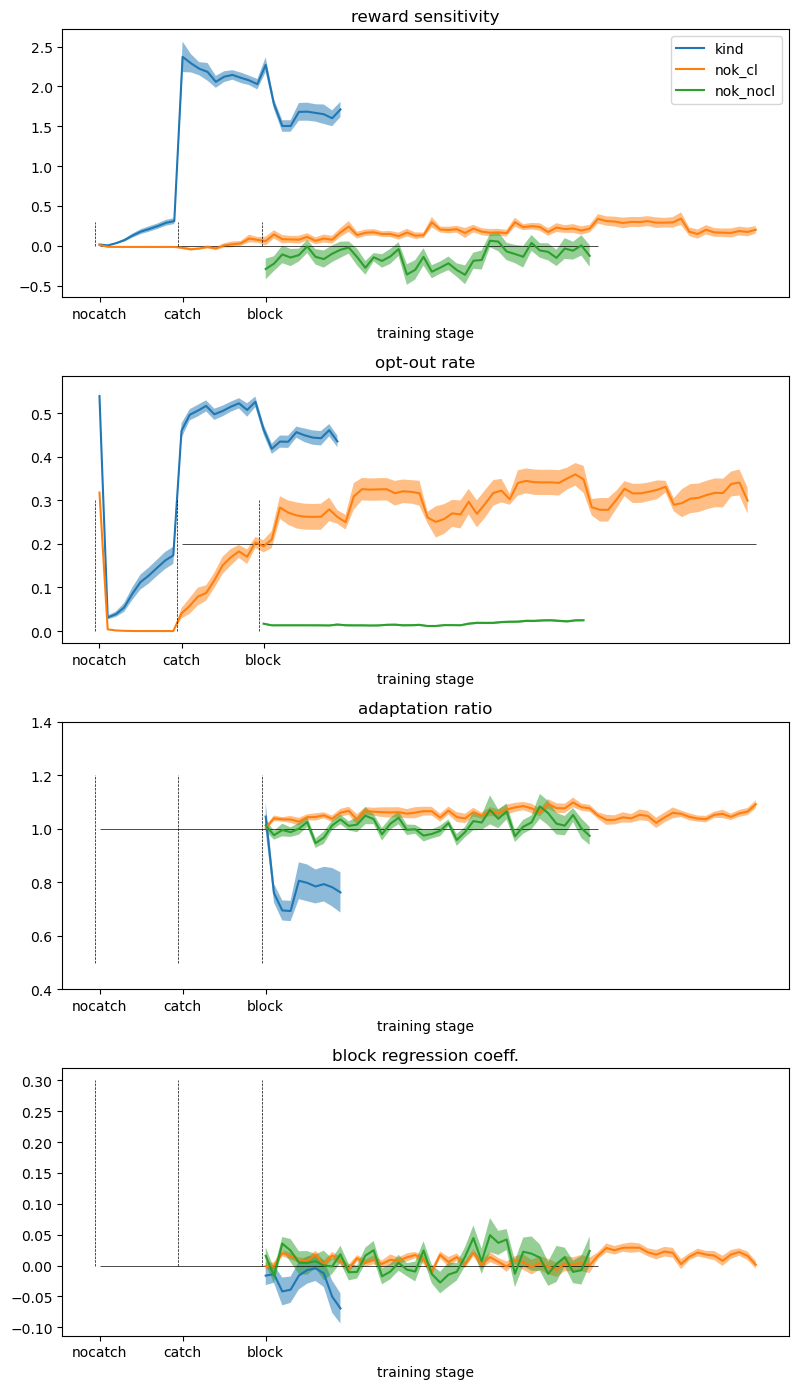

In [10]:
#4D, plot everything behavioral together

#set figure names
labs_fig = np.array(labs)[klist_dict[fig2do]]

#plotting
if fig2do == '4':  # number of RNNs per type
    n1 = slopelist_mask.shape[0]
    n2 = slopelist_nok_cl_mask.shape[0]
    n3 = slopelist_nok_nocl_mask.shape[0]
    print([n1,n2,n3])
elif fig2do == '6':
    n1 = 50
    n2 = 10
    n3 = 10

lmax = max(lenlist)
lmax_nokcl = max(lenlist_nok_cl)
lmax_nocl = max(lenlist_nok_nocl)

fun = np.nanmean

slopemean = fun(slopelist_mask, axis=0)
slopesem = np.nanstd(slopelist_mask, axis=0)/np.sqrt(n1)
optoutmean = fun(optoutlist_mask, axis=0)
optoutsem = np.nanstd(optoutlist_mask, axis=0)/np.sqrt(n1)
ratiomean = fun(ratiolist_mask, axis=0)
ratiosem = np.nanstd(ratiolist_mask, axis=0)/np.sqrt(n1)
blockcoeffmean = fun(block_coeff_list_mask, axis=0)
blockcoeffsem = np.nanstd(block_coeff_list_mask, axis=0)/np.sqrt(n1)

slopemean_nok_cl = fun(slopelist_nok_cl_mask, axis=0)
slopesem_nok_cl = np.nanstd(slopelist_nok_cl_mask, axis=0)/np.sqrt(n2)
optoutmean_nok_cl = fun(optoutlist_nok_cl_mask, axis=0)
optoutsem_nok_cl = np.nanstd(optoutlist_nok_cl_mask, axis=0)/np.sqrt(n2)
ratiomean_nok_cl = fun(ratiolist_nok_cl_mask, axis=0)
ratiosem_nok_cl = np.nanstd(ratiolist_nok_cl_mask, axis=0)/np.sqrt(n2)
blockcoeffmean_nok_cl = fun(block_coeff_list_nok_cl_mask, axis=0)
blockcoeffsem_nok_cl = np.nanstd(block_coeff_list_nok_cl_mask, axis=0)/np.sqrt(n2)


slopemean_nok_nocl = fun(slopelist_nok_nocl_mask, axis=0)
slopesem_nok_nocl = np.nanstd(slopelist_nok_nocl_mask, axis=0)/np.sqrt(n3)
optoutmean_nok_nocl = fun(optoutlist_nok_nocl_mask, axis=0)
optoutsem_nok_nocl = np.nanstd(optoutlist_nok_nocl_mask, axis=0)/np.sqrt(n3)
ratiomean_nok_nocl = fun(ratiolist_nok_nocl_mask, axis=0)
ratiosem_nok_nocl = np.nanstd(ratiolist_nok_nocl_mask, axis=0)/np.sqrt(n3)
blockcoeffmean_nok_nocl = fun(block_coeff_list_nok_nocl_mask, axis=0)
blockcoeffsem_nok_nocl = np.nanstd(block_coeff_list_nok_nocl_mask, axis=0)/np.sqrt(n3)


fig,ax = plt.subplots(4,1,figsize = (8,14))

ax[0].hlines(0.0, 0,lmax_nocl, color = 'k', linewidth = 0.5)
ax[0].plot(range(lmax),slopemean, label = labs_fig[0])
ax[0].fill_between(range(lmax),slopemean-slopesem, slopemean+slopesem, alpha = 0.5)
ax[0].plot(range(lmax_nokcl),slopemean_nok_cl, label = labs_fig[1])
ax[0].fill_between(range(lmax_nokcl),slopemean_nok_cl-slopesem_nok_cl, slopemean_nok_cl+slopesem_nok_cl, alpha = 0.5)
ax[0].plot(range(lmax_nocl),slopemean_nok_nocl, label = labs_fig[2])
ax[0].fill_between(range(lmax_nocl),slopemean_nok_nocl-slopesem_nok_nocl, slopemean_nok_nocl+slopesem_nok_nocl, alpha = 0.5)
ax[0].legend()

ax[1].hlines(0.2, 10,20+lmax_nocl, color = 'k', linewidth = 0.5)
ax[1].plot(range(lmax),optoutmean)
ax[1].fill_between(range(lmax),optoutmean-optoutsem, optoutmean+optoutsem, alpha = 0.5)
ax[1].plot(range(lmax_nokcl),optoutmean_nok_cl)
ax[1].fill_between(range(lmax_nokcl),optoutmean_nok_cl-optoutsem_nok_cl, optoutmean_nok_cl+optoutsem_nok_cl, alpha = 0.5)
ax[1].plot(range(lmax_nocl),optoutmean_nok_nocl)
ax[1].fill_between(range(lmax_nocl),optoutmean_nok_nocl-optoutsem_nok_nocl, optoutmean_nok_nocl+optoutsem_nok_nocl, alpha = 0.5)

ax[2].hlines(1.0, 0,lmax_nocl, color = 'k', linewidth = 0.5)
ax[2].plot(range(lmax),ratiomean)
ax[2].fill_between(range(lmax),ratiomean-ratiosem, ratiomean+ratiosem, alpha = 0.5)
ax[2].plot(range(lmax_nokcl),ratiomean_nok_cl)
ax[2].fill_between(range(lmax_nokcl),ratiomean_nok_cl-ratiosem_nok_cl, ratiomean_nok_cl+ratiosem_nok_cl, alpha = 0.5)
ax[2].plot(range(lmax_nocl),ratiomean_nok_nocl)
ax[2].fill_between(range(lmax_nocl),ratiomean_nok_nocl-ratiosem_nok_nocl, ratiomean_nok_nocl+ratiosem_nok_nocl, alpha = 0.5)
if fig2do == '3':
    ax[2].set_ylim([0.4,1.2])
else:
    ax[2].set_ylim([0.4,1.4])

ax[3].hlines(0.0, 0,+lmax_nocl, color = 'k', linewidth = 0.5)
ax[3].plot(range(lmax),blockcoeffmean)
ax[3].fill_between(range(lmax),blockcoeffmean-blockcoeffsem, blockcoeffmean+blockcoeffsem, alpha = 0.5)
ax[3].plot(range(lmax_nokcl),blockcoeffmean_nok_cl)
ax[3].fill_between(range(lmax_nokcl),blockcoeffmean_nok_cl-blockcoeffsem_nok_cl, blockcoeffmean_nok_cl+blockcoeffsem_nok_cl, alpha = 0.5)
ax[3].plot(range(lmax_nocl),blockcoeffmean_nok_nocl)
ax[3].fill_between(range(lmax_nocl),blockcoeffmean_nok_nocl-blockcoeffsem_nok_nocl, blockcoeffmean_nok_nocl+blockcoeffsem_nok_nocl, alpha = 0.5)
if fig2do == '3':
    ax[3].set_ylim([-0.1,0.1])
elif fig2do == '5':
    ax[3].set_ylim([-0.15,0.15])


#find a completed network and grab its stagelist
stagelist = stagelist_list[np.argmax(lenlist_nok_cl)]
stagedict = {0:'simple', 1:'int', 2:'pred', 3:'nocatch', 4:'catch', 5:'block', 6:'freeze'}
typeloc = [np.argwhere(stagelist == k)[0,0] for k in np.unique(stagelist) ]


for j in range(4):
    [ax[j].vlines(k-0.5,  0, 0.3, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]
    ax[j].set_xticks(typeloc, labels = [stagedict[stagelist[k]] for k in typeloc], rotation = 0)
    ax[j].set_xlabel('training stage')
    #ax[j].set_ylabel('wt slope')

[ax[2].vlines(k-0.5,  0.5, 1.2, color='k',linewidth = 0.5, linestyle = 'dashed') for k in typeloc]


ax[0].set_title('reward sensitivity')
ax[1].set_title('opt-out rate')
ax[2].set_title('adaptation ratio')
ax[3].set_title('block regression coeff.')

plt.tight_layout()


plt.show()

    

    